# Control Flow Graph Features

## Setup

In [1]:
import os
import pandas as pd
from pathlib import Path
import json
import re

from collections import Counter
import matplotlib.pyplot as plt
from evmdasm import EvmBytecode

In [2]:
PATH = Path.cwd().parents[1]
DATA_PATH = os.path.join(PATH, 'data')
NAME = 'crpwarner'
IN_PATH = os.path.join(DATA_PATH, f'external/{NAME}/groundtruth/hex')
OUT_PATH = os.path.join(DATA_PATH, f'interim/{NAME}')
PRO_PATH = os.path.join(DATA_PATH, 'processed')
STAT_PATH = os.path.join(PRO_PATH, 'graphs_stat')
GL_PATH = os.path.join(PRO_PATH, 'graphs_labels')
df = pd.read_csv(os.path.join(OUT_PATH, 'dataset-modified.csv')).set_index('address')

## Install Dependencies

In [3]:
!pip install networkx graphviz matplotlib tqdm

In [4]:
!git clone https://github.com/crytic/evm_cfg_builder.git
%cd evm_cfg_builder
!pip install -e .


fatal: destination path 'evm_cfg_builder' already exists and is not an empty directory.
/Users/napatcholthaipanich/Dev/master/dissertation/workspace/ml/notebooks/feature_extraction/evm_cfg_builder
Obtaining file:///Users/napatcholthaipanich/Dev/master/dissertation/workspace/ml/notebooks/feature_extraction/evm_cfg_builder
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for evm-cfg-builder (pyproject.toml) ... done
  Created wheel for evm-cfg-builder: filename=evm_cfg_builder-0.3.1-0.editable-py3-none-any.whl size=16157 sha256=e53f3c77a1e4b0a475d92abf76db70e3ecb41b3b0356fcebe1a8684868107f67
  Stored in directory: /private/var/folders/c8/rmlp9g456b5_c_vt71ncc0nm0000gn/T/pip-ephem-wheel-cache-j59gprp9/wheels/9c/fe/4a/c7e0672f9d04ccf6a889a3e5aee66e0f0ef98807b14e31f1f4
Successfully built evm-cfg-builder
  Attemptin

## Load Bytecode

In [5]:
def load_bytecode(file_path):
    with open(file_path, 'r') as f:
        return f.read().strip()


## Use EVM_CFG_Builder on .hex Bytecode

In [6]:
import networkx as nx

def cfg_to_nx(cfg):
    G = nx.DiGraph()
    for bb in cfg.basic_blocks:
        G.add_node(bb.start.pc)  # You could also use bb.idx or bb.start.offset
        for out in bb.all_outgoing_basic_blocks:
            G.add_edge(bb.start.pc, out.start.pc)
    return G

In [7]:
from evm_cfg_builder.cfg.cfg import CFG

def get_cfg_from_file(hex_file):
    bytecode = load_bytecode(hex_file)
    return CFG(bytecode)


## Extract Graph Features

In [8]:
def extract_graph_features(G):
    return {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "density": nx.density(G),
        "connected_components": nx.number_weakly_connected_components(G),
        "avg_clustering": nx.average_clustering(G.to_undirected())
    }


## Build Dataset

In [9]:
hex_dir = Path(IN_PATH)
all_files = list(hex_dir.glob('*.hex'))

records = []
graphs = []
labels = []
for file in all_files:
    address = file.stem.lower()  # remove '.hex' and lowercase
    cfg = get_cfg_from_file(file)
    nx_graph = cfg_to_nx(cfg)
    feats = extract_graph_features(nx_graph)
    feats['address'] = address
    records.append(feats)
    if address in df.index:
        label_row = df.loc[address]
        labels.append(label_row.to_dict())
        graphs.append(nx_graph)

feature_df = pd.DataFrame(records).fillna(0).set_index('address')
feature_df.head()

,num_nodes,num_edges,avg_degree,density,connected_components,avg_clustering
address,,,,,,
0x8275ebf521dc217aa79c88132017a5bcef001dd9,155,118,1.522581,0.004943,44,0.000000
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,194,96,0.989691,0.002564,112,0.012027
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,339,178,1.050147,0.001553,192,0.003933
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,113,78,1.380531,0.006163,46,0.000000
0x9db8a10c7fe60d84397860b3af2e686d4f90c2b7,303,211,1.392739,0.002306,122,0.007701


In [10]:
df.to_csv(os.path.join(OUT_PATH, 'graphs_stat.csv'))

## Export Labels & Feature Columns

In [11]:
labels = list(df.columns)
features = list(feature_df.columns)
with open(os.path.join(STAT_PATH, 'labels.json'), "w") as f:
    json.dump(labels, f, indent=2)

with open(os.path.join(STAT_PATH, 'features.json'), "w") as f:
    json.dump(features, f, indent=2)

## Merge with Labels Dataframe

In [12]:
df = df.merge(feature_df, left_index=True, right_index=True)
df.select_dtypes(float).fillna(0).astype(int)
df.head()

,mint,leak,limit,num_nodes,num_edges,avg_degree,density,connected_components,avg_clustering
address,,,,,,,,,
0x93023f1d3525e273f291b6f76d2f5027a39bf302,1,0,1,234,113,0.965812,0.002073,142,0.005698
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,339,178,1.050147,0.001553,192,0.003933
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,9,4,0.888889,0.055556,5,0.000000
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,477,145,0.607966,0.000639,347,0.000000
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,649,170,0.523883,0.000404,499,0.000000


In [13]:
df.to_csv(os.path.join(STAT_PATH, 'dataset.csv'))

## Store Graphs + Labels Together

In [14]:
import pickle

with open(os.path.join(GL_PATH, "graphs_with_labels.pkl"), "wb") as f:
    pickle.dump((graphs, labels), f)

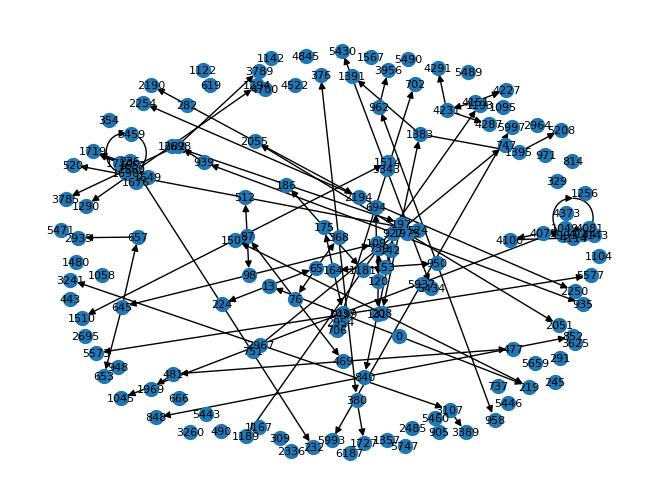

In [15]:
import matplotlib.pyplot as plt

nx.draw(graphs[0], with_labels=True, node_size=100, font_size=8)
plt.show()